In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
from functools import reduce
from sklearn import preprocessing
import matplotlib
matplotlib.use('nbagg')
from matplotlib import pyplot
from keras import models
from keras import layers
from keras import regularizers

from math import sqrt
from numpy import concatenate
from matplotlib import pyplot
from pandas import read_csv
from pandas import DataFrame
from pandas import concat
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import mean_squared_error
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM

from importlib import reload
reload(pyplot)
%matplotlib notebook
%matplotlib notebook


Using TensorFlow backend.


In [2]:
#Import OANDA Data
df_AAPL1 = pd.read_csv('Data_Investingcom/AAPL1')
df_AAPL2 = pd.read_csv('Data_Investingcom/AAPL2')
df_NASDAQ1 = pd.read_csv('Data_Investingcom/NASDAQ1')
df_NASDAQ2 = pd.read_csv('Data_Investingcom/NASDAQ2')


In [3]:
#print(df_eurusd1)
#print(df_eurusd2)
#print(df_eurusd3)

In [4]:
df_AAPL = pd.concat([df_AAPL2,df_AAPL1])
df_NASDAQ = pd.concat([df_NASDAQ2, df_NASDAQ1])
dfs = [df_AAPL, df_NASDAQ]

dfm = reduce(lambda left,right: pd.merge(left,right,on='Date'), dfs)

dfm.index.name = 'number'
dfm = dfm.drop(['Open_AAPL', 'Change %_AAPL', 'Open_NASDAQ', 'Vol._NASDAQ', 'Change %_NASDAQ'], axis=1)

dfm.head()



,Date,Price_AAPL,High_AAPL,Low_AAPL,Vol._AAPL,Price_NASDAQ,High_NASDAQ,Low_NASDAQ
number,,,,,,,,
0,"Nov 23, 2018",172.29,176.53,172.15,23.62M,"6,938.98","6,987.89","6,919.16"
1,"Nov 21, 2018",176.78,180.27,176.55,31.12M,"6,972.25","7,029.93","6,951.62"
2,"Nov 20, 2018",176.98,181.47,175.51,67.83M,"6,908.82","6,994.75","6,830.76"
3,"Nov 19, 2018",185.86,190.70,184.99,41.92M,"7,028.48","7,224.12","7,011.40"
4,"Nov 16, 2018",193.53,194.97,189.46,36.93M,"7,247.87","7,274.86","7,171.70"


In [5]:
new_price = []
for price in dfm['Price_NASDAQ']:
    newprice= ""
    for figure in price:
        figure = figure.replace(",","")
        newprice = newprice + figure
    new_price.append(newprice)
dfm['Price_NASDAQ'] = new_price

new_price = []
for price in dfm['High_NASDAQ']:
    newprice= ""
    for figure in price:
        figure = figure.replace(",","")
        newprice = newprice + figure
    new_price.append(newprice)
dfm['High_NASDAQ'] = new_price

new_price = []
for price in dfm['Low_NASDAQ']:
    newprice= ""
    for figure in price:
        figure = figure.replace(",","")
        newprice = newprice + figure
    new_price.append(newprice)
dfm['Low_NASDAQ'] = new_price

new_price = []
for vol in dfm['Vol._AAPL']:
    newprice= ""
    for figure in vol:
        figure = figure.replace(".","")
        figure = figure.replace("M", "000000")
        figure = figure.replace("B", "000000000")
        figure = figure.replace("K", "000")                        
        newprice = newprice + figure
    new_price.append(newprice)
dfm['Vol._AAPL'] = new_price

dfm.head()
        

,Date,Price_AAPL,High_AAPL,Low_AAPL,Vol._AAPL,Price_NASDAQ,High_NASDAQ,Low_NASDAQ
number,,,,,,,,
0,"Nov 23, 2018",172.29,176.53,172.15,2362000000,6938.98,6987.89,6919.16
1,"Nov 21, 2018",176.78,180.27,176.55,3112000000,6972.25,7029.93,6951.62
2,"Nov 20, 2018",176.98,181.47,175.51,6783000000,6908.82,6994.75,6830.76
3,"Nov 19, 2018",185.86,190.70,184.99,4192000000,7028.48,7224.12,7011.40
4,"Nov 16, 2018",193.53,194.97,189.46,3693000000,7247.87,7274.86,7171.70


In [6]:
scaler = MinMaxScaler(feature_range=(0, 1))
dfm_scaled = scaler.fit_transform(dfm.values[:,1:])
dfm.loc[:,1:] = dfm_scaled
dfm.head()

,Date,Price_AAPL,High_AAPL,Low_AAPL,Vol._AAPL,Price_NASDAQ,High_NASDAQ,Low_NASDAQ
number,,,,,,,,
0,"Nov 23, 2018",0.742183,0.755905,0.748976,0.012515,0.852751,0.856360,0.853520
1,"Nov 21, 2018",0.761547,0.771938,0.768142,0.016548,0.856936,0.861632,0.857618
2,"Nov 20, 2018",0.762410,0.777082,0.763612,0.036288,0.848958,0.857220,0.842358
3,"Nov 19, 2018",0.800707,0.816650,0.804905,0.022355,0.864008,0.885984,0.865166
4,"Nov 16, 2018",0.833786,0.834955,0.824375,0.019672,0.891602,0.892347,0.885405


In [7]:
dfm.to_csv('mergeddata.csv')

In [8]:
#step two

In [9]:
#Define function to add timesteps in datafram
def series_to_supervised(data, n_in=1, n_out=1, dropnan=True):
	"""
	Frame a time series as a supervised learning dataset.
	Arguments:
		data: Sequence of observations as a list or NumPy array.
		n_in: Number of lag observations as input (X).
		n_out: Number of observations as output (y).
		dropnan: Boolean whether or not to drop rows with NaN values.
	Returns:
		Pandas DataFrame of series framed for supervised learning.
	"""
	n_vars = 1 if type(data) is list else data.shape[1]
	df = pd.DataFrame(data)
	cols, names = list(), list()
	# input sequence (t-n, ... t-1)
	for i in range(n_in, 0, -1):
		cols.append(df.shift(i))
		names += [('var%d(t-%d)' % (j+1, i)) for j in range(n_vars)]
	# forecast sequence (t, t+1, ... t+n)
	for i in range(0, n_out):
		cols.append(df.shift(-i))
		if i == 0:
			names += [('var%d(t)' % (j+1)) for j in range(n_vars)]
		else:
			names += [('var%d(t+%d)' % (j+1, i)) for j in range(n_vars)]
	# put it all together
	agg = pd.concat(cols, axis=1)
	agg.columns = names
	# drop rows with NaN values
	if dropnan:
		agg.dropna(inplace=True)
	return agg

In [10]:
#Add timesteps to the dataframe
dfm = pd.read_csv('mergeddata.csv', header=0, index_col=1)
values = dfm.values
n_days = 25
dfm = dfm.drop(['number'], axis = 1)
dfm

,Price_AAPL,High_AAPL,Low_AAPL,Vol._AAPL,Price_NASDAQ,High_NASDAQ,Low_NASDAQ
Date,,,,,,,
"Nov 23, 2018",0.742183,0.755905,0.748976,0.012515,0.852751,0.856360,0.853520
"Nov 21, 2018",0.761547,0.771938,0.768142,0.016548,0.856936,0.861632,0.857618
"Nov 20, 2018",0.762410,0.777082,0.763612,0.036288,0.848958,0.857220,0.842358
"Nov 19, 2018",0.800707,0.816650,0.804905,0.022355,0.864008,0.885984,0.865166
"Nov 16, 2018",0.833786,0.834955,0.824375,0.019672,0.891602,0.892347,0.885405
...,...,...,...,...,...,...,...
"Dec 18, 1980",0.001208,0.001200,0.001220,0.009686,0.004637,0.004624,0.004655
"Dec 17, 1980",0.001121,0.001115,0.001133,0.011434,0.004387,0.004374,0.004404
"Dec 16, 1980",0.001078,0.001072,0.001089,0.014026,0.004118,0.004106,0.004134


In [11]:
dfm[dfm.index.duplicated()]
dfm = dfm.reindex(index=dfm.index[::-1])

dfm.head()

,Price_AAPL,High_AAPL,Low_AAPL,Vol._AAPL,Price_NASDAQ,High_NASDAQ,Low_NASDAQ
Date,,,,,,,
"Dec 12, 1980",0.001337,0.001372,0.001350,0.062868,0.004035,0.004023,0.004050
"Dec 15, 1980",0.001251,0.001243,0.001263,0.023457,0.004387,0.004374,0.004404
"Dec 16, 1980",0.001078,0.001072,0.001089,0.014026,0.004118,0.004106,0.004134
"Dec 17, 1980",0.001121,0.001115,0.001133,0.011434,0.004387,0.004374,0.004404
"Dec 18, 1980",0.001208,0.001200,0.001220,0.009686,0.004637,0.004624,0.004655


In [12]:
dfm_series = series_to_supervised(dfm, n_days, 1)
dfm_series.head()

,var1(t-25),var2(t-25),var3(t-25),var4(t-25),var5(t-25),var6(t-25),var7(t-25),var1(t-24),var2(t-24),var3(t-24),...,var5(t-1),var6(t-1),var7(t-1),var1(t),var2(t),var3(t),var4(t),var5(t),var6(t),var7(t)
Date,,,,,,,,,,,,,,,,,,,,,
"Jan 20, 1981",0.001337,0.001372,0.001350,0.062868,0.004035,0.004023,0.004050,0.001251,0.001243,0.001263,...,0.005338,0.005322,0.005358,0.001596,0.001586,0.001612,0.003857,0.004978,0.004964,0.004997
"Jan 21, 1981",0.001251,0.001243,0.001263,0.023457,0.004387,0.004374,0.004404,0.001078,0.001072,0.001089,...,0.004978,0.004964,0.004997,0.001639,0.001629,0.001655,0.001953,0.004899,0.004885,0.004918
"Jan 22, 1981",0.001078,0.001072,0.001089,0.014026,0.004118,0.004106,0.004134,0.001121,0.001115,0.001133,...,0.004899,0.004885,0.004918,0.001682,0.001672,0.001699,0.004594,0.004777,0.004763,0.004795
"Jan 23, 1981",0.001121,0.001115,0.001133,0.011434,0.004387,0.004374,0.004404,0.001208,0.001200,0.001220,...,0.004777,0.004763,0.004795,0.001639,0.001672,0.001655,0.001324,0.004827,0.004813,0.004846
"Jan 26, 1981",0.001208,0.001200,0.001220,0.009686,0.004637,0.004624,0.004655,0.001294,0.001329,0.001307,...,0.004827,0.004813,0.004846,0.001639,0.001629,0.001655,0.003126,0.004653,0.004639,0.004670


In [13]:
#get var1(t) to the end
swapcol = list(dfm_series)
#print(swapcol)
swapcol[-6], swapcol[-1] = swapcol[-1], swapcol[-6]
dfm_series = dfm_series.loc[:,swapcol]

In [14]:
#dfm_series.index.name = 'Date'
dfm_series.to_csv('mergeddataseries.csv')
dfm_series.head()

,var1(t-25),var2(t-25),var3(t-25),var4(t-25),var5(t-25),var6(t-25),var7(t-25),var1(t-24),var2(t-24),var3(t-24),...,var5(t-1),var6(t-1),var7(t-1),var1(t),var7(t),var3(t),var4(t),var5(t),var6(t),var2(t)
Date,,,,,,,,,,,,,,,,,,,,,
"Jan 20, 1981",0.001337,0.001372,0.001350,0.062868,0.004035,0.004023,0.004050,0.001251,0.001243,0.001263,...,0.005338,0.005322,0.005358,0.001596,0.004997,0.001612,0.003857,0.004978,0.004964,0.001586
"Jan 21, 1981",0.001251,0.001243,0.001263,0.023457,0.004387,0.004374,0.004404,0.001078,0.001072,0.001089,...,0.004978,0.004964,0.004997,0.001639,0.004918,0.001655,0.001953,0.004899,0.004885,0.001629
"Jan 22, 1981",0.001078,0.001072,0.001089,0.014026,0.004118,0.004106,0.004134,0.001121,0.001115,0.001133,...,0.004899,0.004885,0.004918,0.001682,0.004795,0.001699,0.004594,0.004777,0.004763,0.001672
"Jan 23, 1981",0.001121,0.001115,0.001133,0.011434,0.004387,0.004374,0.004404,0.001208,0.001200,0.001220,...,0.004777,0.004763,0.004795,0.001639,0.004846,0.001655,0.001324,0.004827,0.004813,0.001672
"Jan 26, 1981",0.001208,0.001200,0.001220,0.009686,0.004637,0.004624,0.004655,0.001294,0.001329,0.001307,...,0.004827,0.004813,0.004846,0.001639,0.004670,0.001655,0.003126,0.004653,0.004639,0.001629


In [15]:
#step three

In [16]:
dfm_series = pd.read_csv('mergeddataseries.csv')
dfm_series = dfm_series.set_index('Date')
dfm_series.head()
#print(dfm_series)

,var1(t-25),var2(t-25),var3(t-25),var4(t-25),var5(t-25),var6(t-25),var7(t-25),var1(t-24),var2(t-24),var3(t-24),...,var5(t-1),var6(t-1),var7(t-1),var1(t),var7(t),var3(t),var4(t),var5(t),var6(t),var2(t)
Date,,,,,,,,,,,,,,,,,,,,,
"Jan 20, 1981",0.001337,0.001372,0.001350,0.062868,0.004035,0.004023,0.004050,0.001251,0.001243,0.001263,...,0.005338,0.005322,0.005358,0.001596,0.004997,0.001612,0.003857,0.004978,0.004964,0.001586
"Jan 21, 1981",0.001251,0.001243,0.001263,0.023457,0.004387,0.004374,0.004404,0.001078,0.001072,0.001089,...,0.004978,0.004964,0.004997,0.001639,0.004918,0.001655,0.001953,0.004899,0.004885,0.001629
"Jan 22, 1981",0.001078,0.001072,0.001089,0.014026,0.004118,0.004106,0.004134,0.001121,0.001115,0.001133,...,0.004899,0.004885,0.004918,0.001682,0.004795,0.001699,0.004594,0.004777,0.004763,0.001672
"Jan 23, 1981",0.001121,0.001115,0.001133,0.011434,0.004387,0.004374,0.004404,0.001208,0.001200,0.001220,...,0.004777,0.004763,0.004795,0.001639,0.004846,0.001655,0.001324,0.004827,0.004813,0.001672
"Jan 26, 1981",0.001208,0.001200,0.001220,0.009686,0.004637,0.004624,0.004655,0.001294,0.001329,0.001307,...,0.004827,0.004813,0.004846,0.001639,0.004670,0.001655,0.003126,0.004653,0.004639,0.001629


In [17]:
## create train and test split
n_features = 7
train = dfm_series.values[:9000, :]
test = dfm_series.values[9000:,:]

#split inputs and output
train_X, train_Y = train[:, :-n_features], train[:, -1]
test_X, test_Y = test[:, :-n_features], test[:, -1]

#make the train input 3 dimensional, idk why, think it's required for the lstm
train_X = train_X.reshape((train_X.shape[0], n_days, n_features))
test_X = test_X.reshape((test_X.shape[0], n_days, n_features))

print(train_X.shape, train_Y.shape, test_X.shape, test_Y.shape )

(9000, 25, 7) (9000,) (544, 25, 7) (544,)


In [18]:
#define model
def build_model():
    model = Sequential()
    model.add(LSTM(128, input_shape=(train_X.shape[1], train_X.shape[2])))
    #model.add(LSTM(128, input_shape=(train_X.shape[1], train_X.shape[2])))
    #model.add(LSTM(128))
    model.add(Dense(1))
    model.compile(loss='mse', optimizer='adam', metrics=['mae'])
    return model

In [19]:
#kfold and fit model
k = 2
num_val_samples = len(train_X) // k
num_epochs = 200
size_batch = 64
all_scores = []

for i in range(k):
    print('processing fold #', i)
    val_data = train_X[i * num_val_samples: (i + 1 ) * num_val_samples]
    val_targets = train_Y[i * num_val_samples: (i + 1 ) * num_val_samples]
    
    partial_train_data = np.concatenate(
    [train_X[:i *num_val_samples],
     train_X[(i +1) * num_val_samples: ]],
         axis =0)
    
    partial_train_targets = np.concatenate(
    [train_Y[:i*num_val_samples],
     train_Y[(i + 1) * num_val_samples:]],
         axis = 0)
    
    model = build_model()
    model.fit(partial_train_data, partial_train_targets,
             epochs= num_epochs, batch_size = size_batch, verbose = 0)
    
    val_mse, val_mae = model.evaluate(val_data, val_targets, verbose = 0)
    all_scores.append(val_mae)
    
#show the average mae
print(sum(all_scores)/len(all_scores))

processing fold # 0
processing fold # 1
0.0017049075686372817


In [20]:
#Validate with test set
Y_hat = model.predict(test_X)
Y = test_Y

test_X = test_X.reshape((test_X.shape[0], n_days*n_features))


inv_Y_hat = concatenate((Y_hat, test_X[:, (-n_features+1):]), axis=1)
inv_Y_hat = scaler.inverse_transform(inv_Y_hat)
inv_Y_hat = inv_Y_hat[:,0]

test_Y = test_Y.reshape((len(test_Y),1))
inv_Y = concatenate((test_Y, test_X[:, (-n_features+1):]), axis=1)
inv_Y = scaler.inverse_transform(inv_Y)
inv_Y = inv_Y[:,0]



Y_hat_2 = model.predict(train_X)
Y_2 = train_Y

train_X = train_X.reshape((train_X.shape[0], n_days*n_features))
inv_Y_hat_2 = concatenate((Y_hat_2, train_X[:, (-n_features+1):]), axis=1)
inv_Y_hat_2 = scaler.inverse_transform(inv_Y_hat_2)
inv_Y_hat_2 = inv_Y_hat_2[:,0]

train_Y = train_Y.reshape((len(train_Y),1))
inv_Y_2 = concatenate((train_Y, train_X[:, (-n_features+1):]), axis=1)
inv_Y_2 = scaler.inverse_transform(inv_Y_2)
inv_Y_2 = inv_Y_2[:,0]

# calculate RMSE
rmse = sqrt(mean_squared_error(inv_Y, inv_Y_hat))
print('Test RMSE: %.3f' % rmse)

# calculate RMSE2
rmse2 = sqrt(mean_squared_error(inv_Y_2, inv_Y_hat_2))
print('Train RMSE2: %.3f' % rmse2)



Test RMSE: 6.066
Train RMSE2: 0.859


<IPython.core.display.Javascript object>


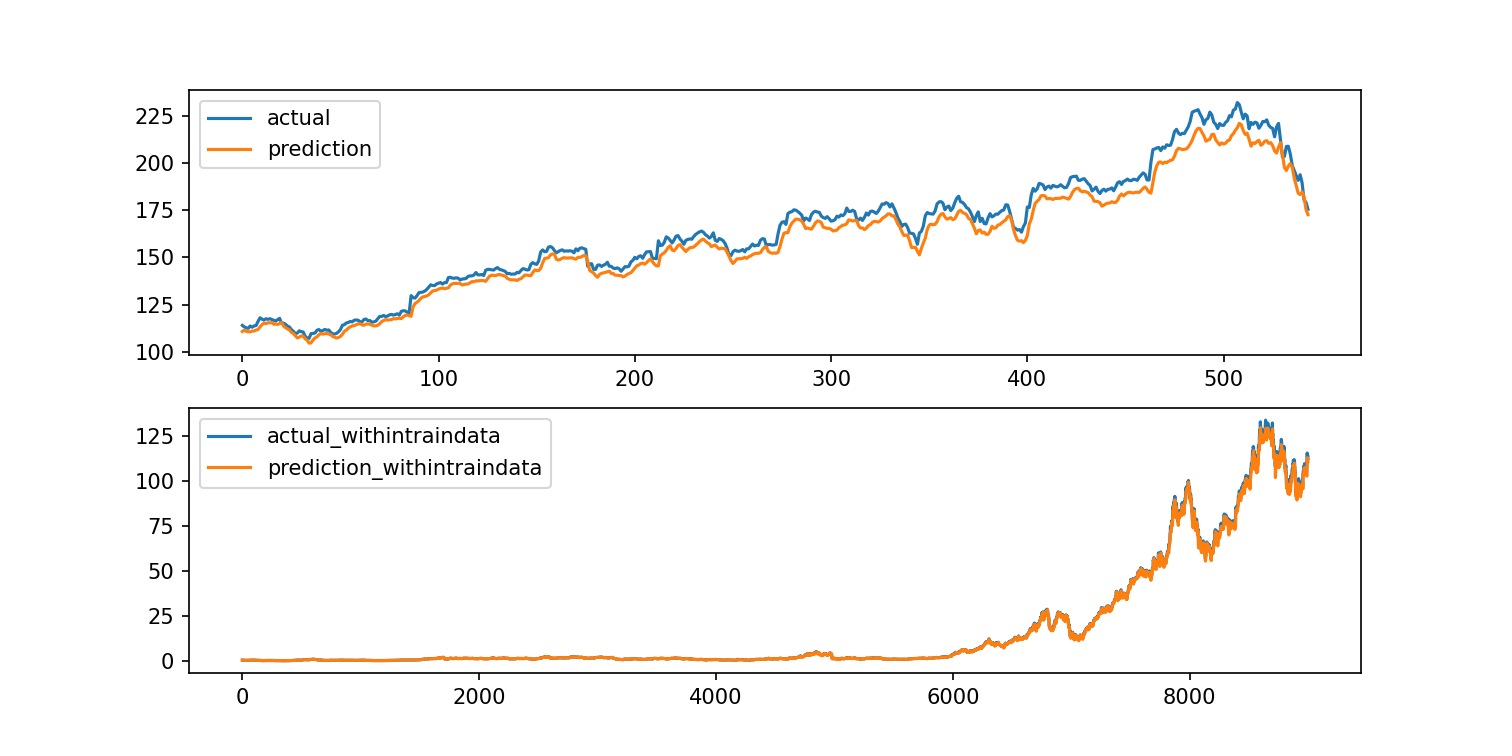

In [21]:

#plot actual stock price and predicted stock price
pyplot.figure(figsize=(10,5))

pyplot.subplot(211)
pyplot.plot(inv_Y, label='actual')
pyplot.plot(inv_Y_hat, label='prediction')
pyplot.legend()

pyplot.subplot(212)
pyplot.plot(inv_Y_2, label='actual_withintraindata')
pyplot.plot(inv_Y_hat_2, label = 'prediction_withintraindata')
pyplot.legend()

pyplot.show()

In [22]:
print(inv_Y)
print(inv_Y_hat)

[113.95317358 113.11821494 112.69079564 112.37271617 113.62515411
 112.97905517 113.65497406 113.87365371 116.05051014 117.97886698
 117.27312813 116.73636901 117.46198783 117.13396836 117.50174776
 117.05444849 116.67672911 116.20954988 117.03456853 117.65084752
 115.00681185 115.16585159 114.51975265 113.54563424 113.08839499
 111.67691731 110.79225876 109.58952073 109.8479603  111.05069833
 110.65309898 110.42447936 108.21780298 107.1641647  107.03494491
 109.56964076 109.68892056 109.87778025 111.31907789 111.74649719
 110.84195867 111.19979809 111.79619711 111.35883783 111.52781755
 110.2753796  109.43048099 109.37084109 109.69886055 110.5238792
 111.75643718 114.01281348 114.31101299 115.22549149 115.50381103
 116.03063017 115.80201055 116.67672911 116.79600892 116.69660908
 115.81195053 115.82189051 117.09420843 117.31288807 116.40834955
 116.49780941 115.63303082 115.81195053 116.15984996 117.45204784
 118.71442577 118.66472585 119.21142496 118.58520598 118.90328546
 119.519564

In [23]:
# Notes
# Still looking to add gridsearch for number of days, number of folds, batch size, number of epochs, 
# number of layers? number of neurons in LSTM layers.

# Want to add a plot where the model is used on another forex, to see wheter the model is just overfitted.

# Try the same procedure for a stock where also trade volume can be used (so not a forex).

# Pull the data through a sigmoid function to make it easier for the model to train.


